In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [13]:
users = pd.read_csv("../data/Users.csv", sep=";", on_bad_lines="skip", encoding="latin-1")
books = pd.read_csv("../data/Books.csv", sep=";", on_bad_lines="skip", encoding="latin-1")
ratings = pd.read_csv("../data/Ratings.csv", sep=";", on_bad_lines="skip", encoding="latin-1")

print("Users shape:", users.shape)
print("Books shape:", books.shape)
print("Ratings shape:", ratings.shape)

print(ratings.head())

Users shape: (278698, 1)
Books shape: (249936, 1)
Ratings shape: (1149780, 1)
  User-ID,ISBN,Book-Rating
0      276725,034545104X,0
1      276726,0155061224,5
2      276727,0446520802,0
3      276729,052165615X,3
4      276729,0521795028,6


In [15]:
print("Users columns:", users.columns.tolist())
print("Books columns:", books.columns.tolist())
print("Ratings columns:", ratings.columns.tolist())

Users columns: ['User-ID,Location,Age']
Books columns: ['ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L']
Ratings columns: ['User-ID,ISBN,Book-Rating']


In [19]:
users = pd.read_csv("../data/Users.csv", sep=",", encoding="latin-1", on_bad_lines="skip")
books = pd.read_csv("../data/Books.csv", sep=",", encoding="latin-1", on_bad_lines="skip", low_memory=False)
ratings = pd.read_csv("../data/Ratings.csv", sep=",", encoding="latin-1", on_bad_lines="skip")

In [20]:
users = users[["User-ID", "Location", "Age"]]
books = books[["ISBN", "Book-Title", "Book-Author", "Year-Of-Publication", "Publisher"]]
ratings = ratings[["User-ID", "ISBN", "Book-Rating"]]

In [21]:
ratings = ratings[ratings["Book-Rating"] > 0]

In [22]:
df = ratings.merge(books, on="ISBN", how="inner")

In [23]:
user_ids = df["User-ID"].unique().tolist()
book_ids = df["ISBN"].unique().tolist()

In [24]:
user2idx = {u: i for i, u in enumerate(user_ids)}
book2idx = {b: i for i, b in enumerate(book_ids)}

df["user"] = df["User-ID"].map(user2idx)
df["item"] = df["ISBN"].map(book2idx)

In [25]:
X = df[["user", "item"]].values
y = df["Book-Rating"].values

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
num_users = len(user2idx)
num_items = len(book2idx)

print("Unique users:", num_users, " | Unique books:", num_items)

Unique users: 68091  | Unique books: 149836


In [28]:
def build_model(num_users, num_items, embedding_size=50):
    user_input = layers.Input(shape=(1,), name="user")
    item_input = layers.Input(shape=(1,), name="item")

    user_embedding = layers.Embedding(num_users, embedding_size)(user_input)
    item_embedding = layers.Embedding(num_items, embedding_size)(item_input)

    user_vec = layers.Flatten()(user_embedding)
    item_vec = layers.Flatten()(item_embedding)

    concat = layers.Concatenate()([user_vec, item_vec])
    dense1 = layers.Dense(128, activation="relu")(concat)
    dense2 = layers.Dense(64, activation="relu")(dense1)
    output = layers.Dense(1, activation="linear")(dense2)

    model = keras.Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer=keras.optimizers.Adam(0.001), loss="mse", metrics=["mae"])
    return model

model = build_model(num_users, num_items, embedding_size=50)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 item (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                3404550   ['user[0][0]']                
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 50)                7491800   ['item[0][0]']                
                                                                                             

In [29]:
history = model.fit(
    [X_train[:,0], X_train[:,1]],
    y_train,
    validation_data=([X_test[:,0], X_test[:,1]], y_test),
    epochs=10,       # start with 10 epochs to test, increase later
    batch_size=256,
    verbose=1
)

Epoch 1/10


1200/1200 [==============================] - 112s 91ms/step - loss: 4.7441 - mae: 1.5491 - val_loss: 2.6568 - val_mae: 1.2549
Epoch 2/10
1200/1200 [==============================] - 104s 87ms/step - loss: 2.0286 - mae: 1.0725 - val_loss: 2.7381 - val_mae: 1.2795
Epoch 3/10
1200/1200 [==============================] - 101s 84ms/step - loss: 1.5137 - mae: 0.8988 - val_loss: 2.9510 - val_mae: 1.3229
Epoch 4/10
1200/1200 [==============================] - 2038s 2s/step - loss: 1.1316 - mae: 0.7700 - val_loss: 3.0046 - val_mae: 1.3290
Epoch 5/10
1200/1200 [==============================] - 110s 91ms/step - loss: 0.8373 - mae: 0.6644 - val_loss: 3.0763 - val_mae: 1.3486
Epoch 6/10
1200/1200 [==============================] - 109s 91ms/step - loss: 0.6229 - mae: 0.5776 - val_loss: 3.1655 - val_mae: 1.3745
Epoch 7/10
1200/1200 [==============================] - 109s 91ms/step - loss: 0.4775 - mae: 0.5114 - val_loss: 3.1189 - val_mae: 1.3563
Epoch 8/10
1200/1200 [==================

In [30]:
y_pred = model.predict([X_test[:,0], X_test[:,1]]).flatten()

rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print("Test RMSE:", rmse)

2400/2400 [==============================] - 5s 2ms/step
Test RMSE: 1.7772257951209383


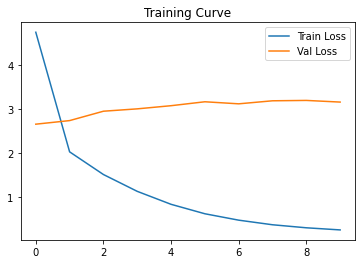

In [31]:
# Plot training
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Training Curve")
plt.show()

In [32]:
model.save("../recommender_model.h5")
print("✅ Model saved as recommender_model.h5")

C:\Users\DEVASISH\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Model saved as recommender_model.h5
